# *Monod* demonstration: identifying differenially regulated genes

We ran the *Monod* inference pipeline on four pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw data, we can apply the $t$-test to spliced count data to identify genes that are differentially expressed (DE) between cell types. Further, we can iteratively it a Gaussian residual model to paired datasets' maximum likelihood physical parameter estimates. This allows us to ascribe changes in distribution shapes to the modulation of the rate of a particular biological process.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [3]:
dataset_meta = ['B08','C01','F08','H12']
cluster_names = ['gaba','glu']
dataset_names_gaba = ['allen_'+x+'_'+cluster_names[0] for x in dataset_meta] 
dataset_names_glu = ['allen_'+x+'_'+cluster_names[1] for x in dataset_meta] 
n_datasets = len(dataset_names_glu)

In [4]:
dir_string = './fits/gg_220602_022_allen_celltypes_1'

result_strings_gaba = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_gaba]
result_strings_glu = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names_glu]

sd_strings_gaba = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_gaba]
sd_strings_glu = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_glu]

In [5]:
result_strings_glu

['./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_F08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_220602_022_allen_celltypes_1/allen_H12_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res']

Load in the GABAergic and glutamatergic datasets.

In [6]:
sr_arr_gaba = []
sr_arr_glu = []

sd_arr_gaba = []
sd_arr_glu = []

for j in range(n_datasets):
    sd = load_search_data(sd_strings_gaba[j])
    sr = load_search_results(result_strings_gaba[j])
    
    sd_arr_gaba.append(sd)
    sr_arr_gaba.append(sr)

    sd = load_search_data(sd_strings_glu[j])
    sr = load_search_results(result_strings_glu[j])
    
    sd_arr_glu.append(sd)
    sr_arr_glu.append(sr)


INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220602_022_allen_celltypes_1/allen_C01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_220602_0

Define basic parameters.

In [7]:
n_phys_pars = sr_arr_gaba[0].sp.n_phys_pars
n_genes = sr_arr_gaba[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr_gaba[0].model.get_log_name_str()
gn = sr_arr_gaba[0].gene_names

## Differential expression and regulation testing within a replicate

First, run the $t$-test to identify potential differences between the means.

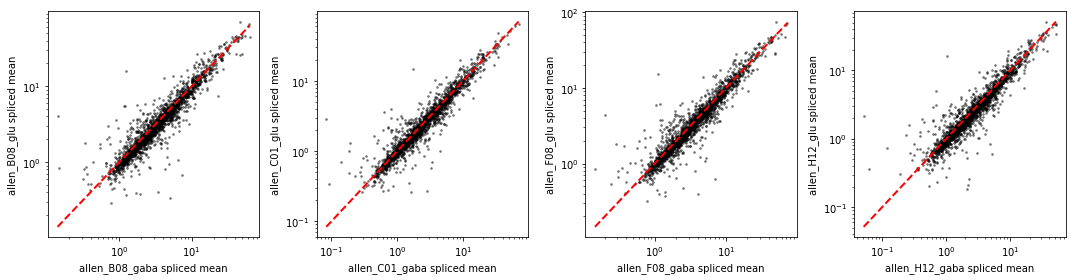

In [8]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))
for j in range(n_datasets):
    m1 = [sd_arr_gaba[j].moments[x]['S_mean']  for x in range(n_genes)]
    m2 = [sd_arr_glu[j].moments[x]['S_mean'] for x in range(n_genes)]
    ax1[j].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[j].set_xscale('log')
    ax1[j].set_yscale('log')
    ax1[j].set_xlabel(dataset_names_gaba[j] +' spliced mean')
    ax1[j].set_ylabel(dataset_names_glu[j] +' spliced mean')
#     ax1[j].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[j].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

fig_string = sr_arr_gaba[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string,dpi=450)


The differences between the means are quite small. Here, we use the size- and $\log_2$-normalized count data for the $t$-test, and show the differences between their means as the fold change.

/home/ggorin/projects/seq-cme-technoise/analysis.py:637: RuntimeWarning: divide by zero encountered in log10
  pv = -np.log10(p)


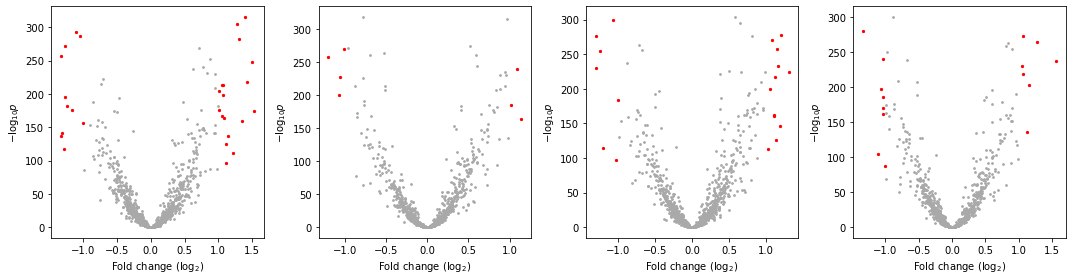

In [9]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))

de_ttest = np.zeros((n_datasets,n_genes),dtype=bool)

for j in range(n_datasets):
    gf_ttest,fc_ = compute_diffexp(sd_arr_gaba[j],sd_arr_glu[j],lognormalize=True,viz=True,method='ttest',
                                   ax1=ax1[j],pval_thr=pval_thr,bonferroni=False) #note Bonferroni has already been applied
    de_ttest[j,:] = gf_ttest
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)


Now, we inspect the inferred parameter values.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_B08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_C01.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_F08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/pair_parameter_comparison_H12.png.


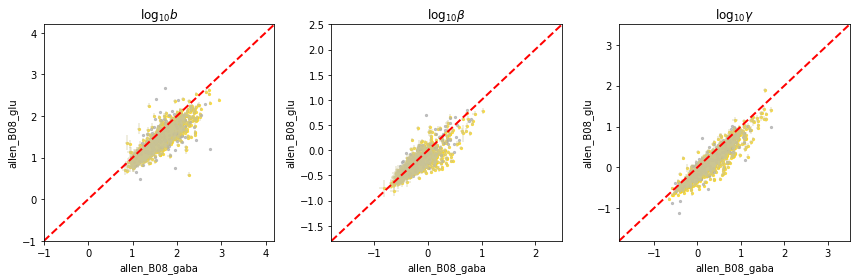

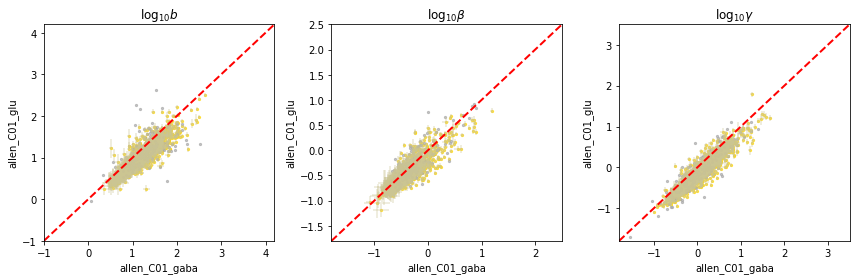

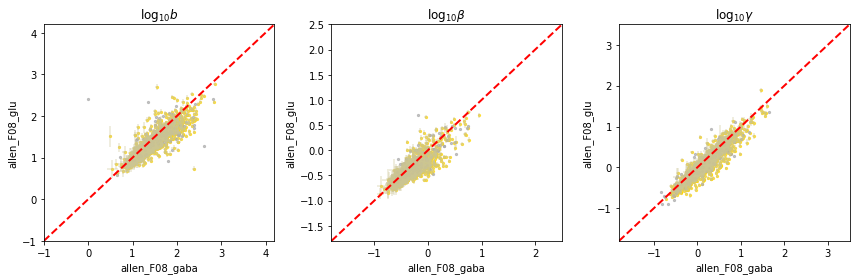

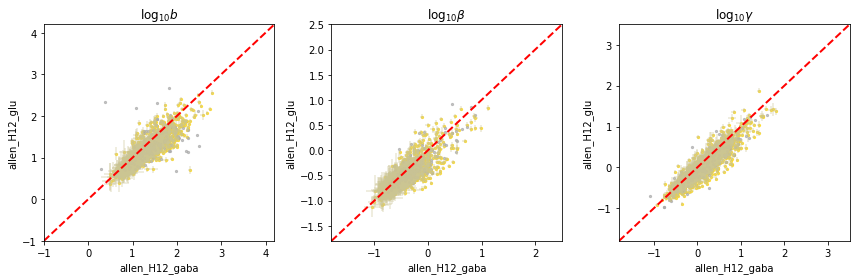

In [10]:
for j in range(n_datasets):
    plot_params_for_pair(sr_arr_gaba[j],sr_arr_glu[j],\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[j],xlabel = dataset_names_gaba[j],\
                         ylabel = dataset_names_glu[j])

Perform differential regulation analysis.

INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_B08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_C01.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_F08.png.
INFO:root:Figure stored to ./fits/gg_220602_022_allen_celltypes_1/analysis_figures/parameter_residuals_H12.png.


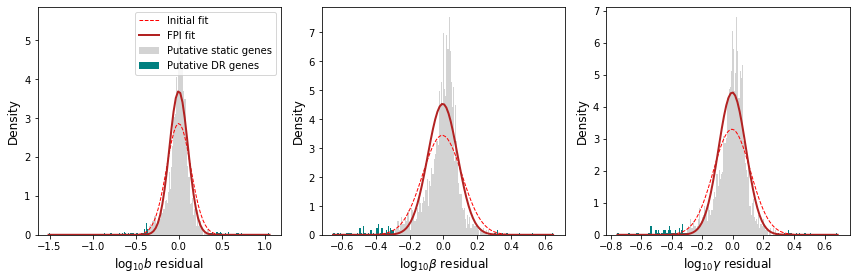

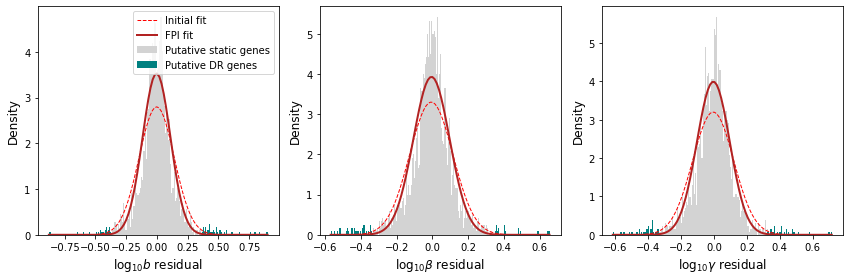

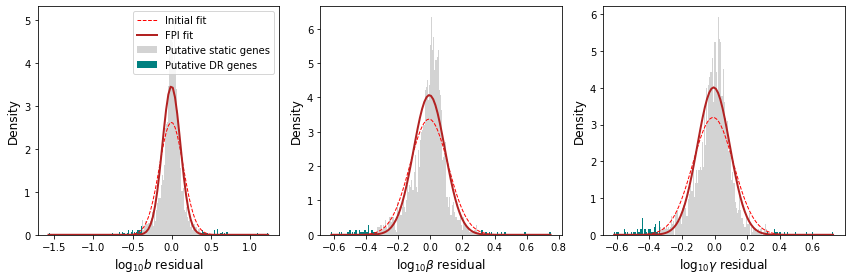

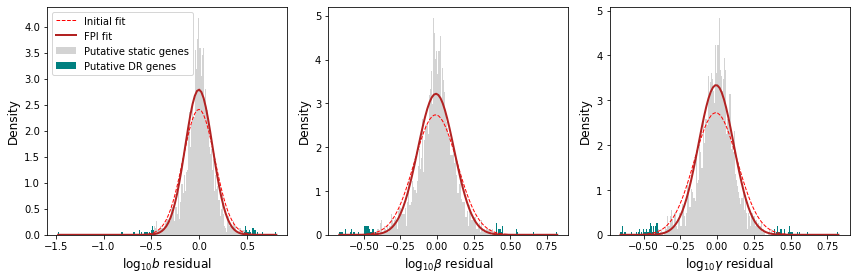

In [11]:
dr_analysis = []
for j in range(n_datasets):
    dr_analysis.append(compute_diffreg(sr_arr_gaba[j],sr_arr_glu[j],viz=True,modeltype='id',
                                       meta=dataset_meta[j],use_sigma=True,pval_thr=0.001,nit=20))

In [12]:
dr_par = np.swapaxes(np.asarray([x[1] for x in dr_analysis]),1,2)
fc_par = np.swapaxes(np.asarray([x[3]/np.log10(2) for x in dr_analysis]),1,2)

Are these modulation patterns correlated? We find that the degradation and splicing rate modulation covaries.

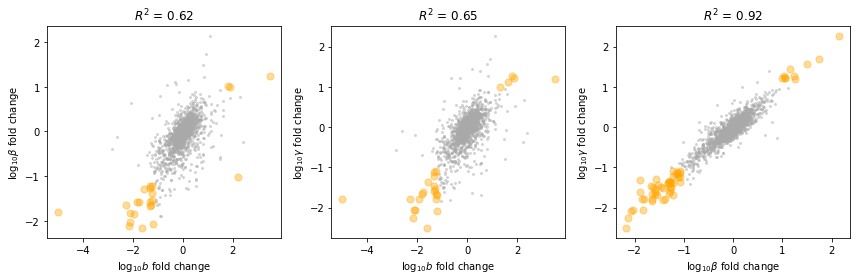

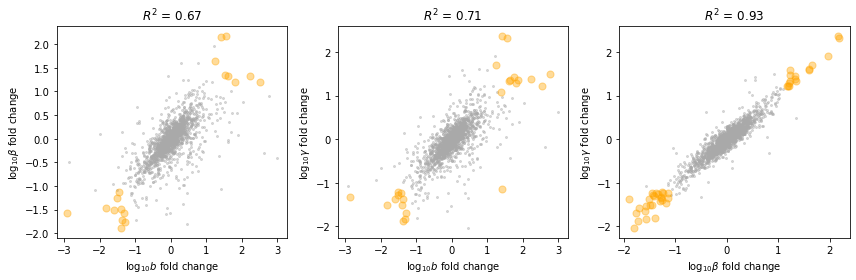

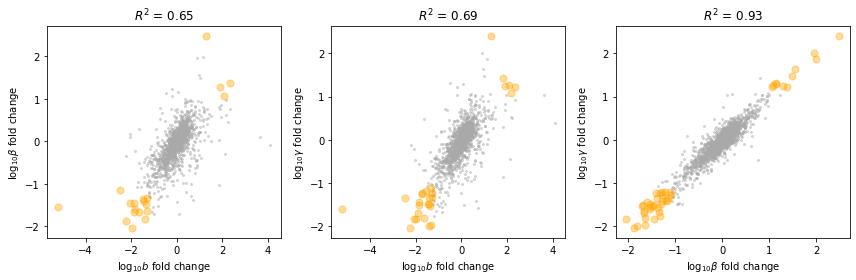

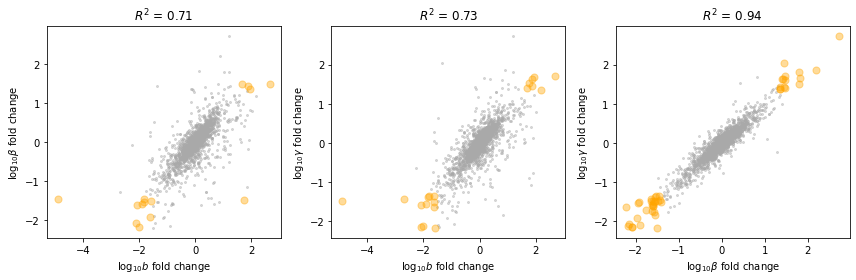

In [13]:
pairs = [[0,1],[0,2],[1,2]]
q=0
for j in range(n_datasets):
    fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
    q=0
    for pair in pairs:
        k1 = pair[0]
        k2 = pair[1]
        gf = dr_par[j,:,k1] & dr_par[j,:,k2]

        x = fc_par[j,:,k1]
        y = fc_par[j,:,k2]
        x[np.isnan(x)] = 0 
        y[np.isnan(y)] = 0

        ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
        ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
        ax1[q].set_xlabel(param_names[k1]+' fold change')
        ax1[q].set_ylabel(param_names[k2]+' fold change')
        xl = [x.min(),y.max()]
        cc = np.corrcoef(x,y)[0,1]
        ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
        q+=1
    fig1.tight_layout()

## Differential expression testing with biological replicates

Obtain $\log_2$ mean expression values across the four datasets for each cell type

In [14]:
par_vals_uncorrected = np.zeros((2,n_datasets,n_genes,n_phys_pars))
mean_vals = np.zeros((2,n_datasets,n_genes))
sigma_vals = np.zeros((2,n_datasets,n_genes,n_phys_pars))
for j in range(n_datasets):
    par_vals_uncorrected[0,j,:,:] = sr_arr_gaba[j].phys_optimum
    par_vals_uncorrected[1,j,:,:] = sr_arr_glu[j].phys_optimum
    mean_vals[0,j,:] = np.log2([x['S_mean'] for x in sd_arr_gaba[j].moments])
    mean_vals[1,j,:] = np.log2([x['S_mean'] for x in sd_arr_glu[j].moments])
    sigma_vals[0,j,:,:] = sr_arr_gaba[j].sigma
    sigma_vals[1,j,:,:] = sr_arr_glu[j].sigma


Then, run a $t$-test on those values.

Text(0, 0.5, 'Glu $\\log_2$ mean')

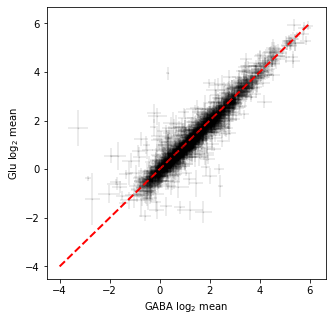

In [15]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.errorbar(mean_vals[0,:,:].mean(0),mean_vals[1,:,:].mean(0),
                 mean_vals[0,:,:].std(0),mean_vals[1,:,:].std(0),'k.',alpha=0.1,markersize=1)

xl = [-4,6]
plt.plot(xl,xl,'r--',linewidth=2)
plt.xlabel('GABA $\log_2$ mean')
plt.ylabel('Glu $\log_2$ mean')

In [16]:
p_mean = np.zeros(n_genes)
for i in range(n_genes):
    p_mean[i] = scipy.stats.ttest_ind(mean_vals[0,:,i],mean_vals[1,:,i],equal_var=False)[1]

We only have four data points, so the $t$-test does not have much power; we only find four genes we can confidently say are DE.

Text(0.5, 0, '$\\mu$ fold change across 4 datasets')

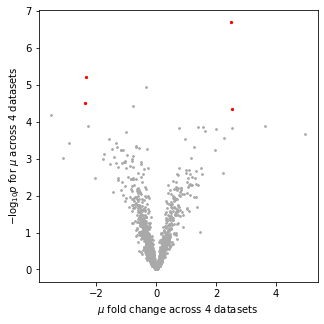

In [17]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

fc_mean = (mean_vals[1,:,:]-mean_vals[0,:,:]).mean(0)
gf_pval = p_mean<pval_thr

gf_fc = np.abs(fc_mean)>1

de_ttest_multi = gf_pval & gf_fc

logp_mean = -np.log10(p_mean)
ax1.scatter(fc_mean[de_ttest_multi],logp_mean[de_ttest_multi],color='r',s=5)
ax1.scatter(fc_mean[~de_ttest_multi],logp_mean[~de_ttest_multi],color='darkgray',s=3)
ax1.set_ylabel(r'$-\log_{10} p$ for $\mu$ across 4 datasets')
ax1.set_xlabel(r'$\mu$ fold change across 4 datasets')


## Differential regulation testing with biological replicates

Inspect the fit parameter values. We observe offsets and hypothesize these are due to imprecision in the sampling parameter fits.

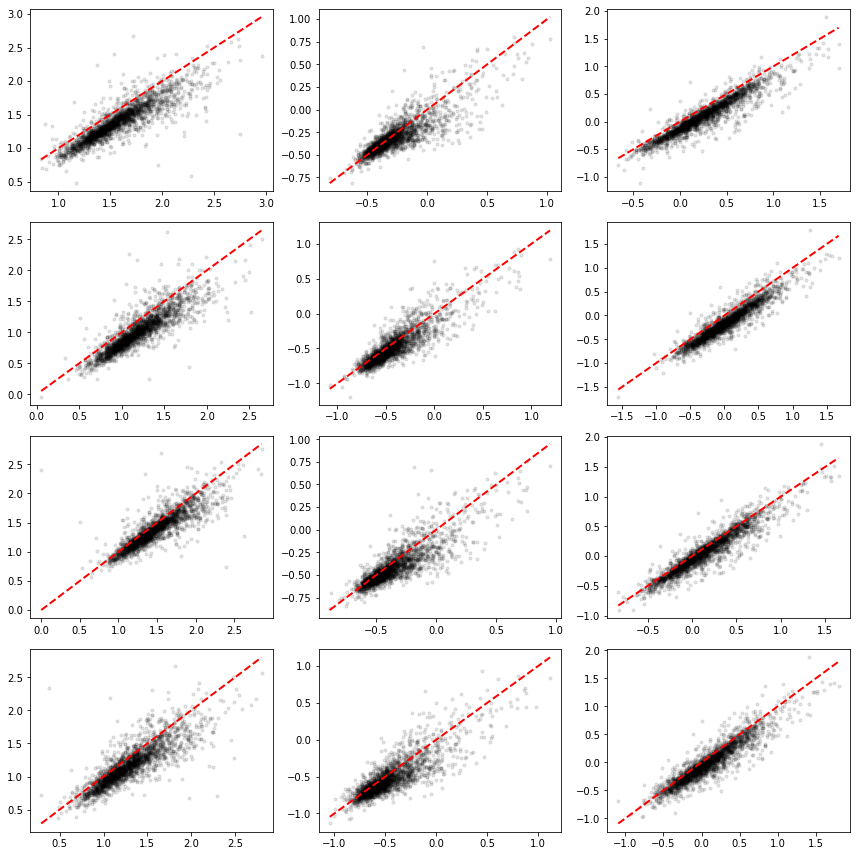

In [18]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals_uncorrected[0,d,:,k]
        y=par_vals_uncorrected[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [19]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
for k in range(n_phys_pars):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[0,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[0,j,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[1,j,:,k]
        offset = diffreg_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[1,j,:,k] -= offset
    
    

Inspect the fit parameter values after correction.

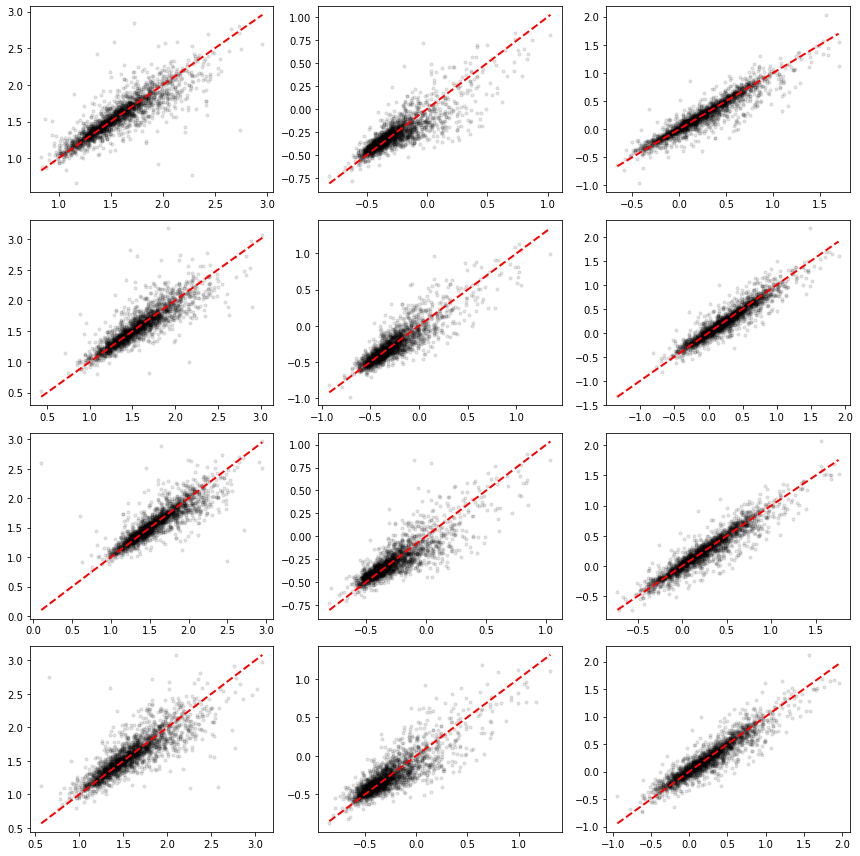

In [20]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals[0,d,:,k]
        y=par_vals[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Plot average and standard deviation across four datasets.

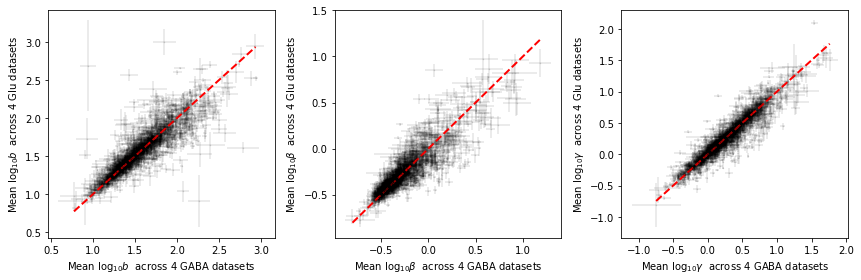

In [21]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []
for k in range(n_phys_pars):
    x=par_vals[0,:,:,k].mean(0)
    y=par_vals[1,:,:,k].mean(0)
    xl = [min(x),max(x)]
    ax1[k].errorbar(x,y,
                     par_vals[0,:,:,k].std(0),par_vals[1,:,:,k].std(0),'k.',alpha=0.1,markersize=1) 
    
    ax1[k].plot(xl,xl,'r--',linewidth=2)
    ax1[k].set_xlabel(r'Mean '+param_names[k]+'  across 4 GABA datasets')
    ax1[k].set_ylabel(r'Mean '+param_names[k]+'  across 4 Glu datasets')
fig1.tight_layout()

In [22]:
p_par = np.zeros((n_genes,n_phys_pars))
for k in range(n_phys_pars):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[0,:,j,k],par_vals[1,:,j,k],equal_var=False)[1]
    

Use an analogous $t$-test to identify DR genes, then plot against mean fold change in the parameter value.

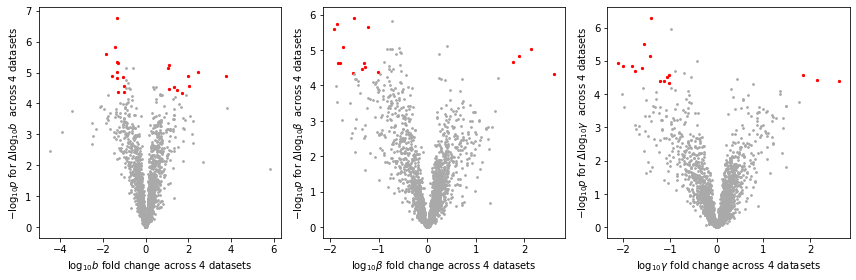

In [23]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
fc_par_multi = ((par_vals[1,:,:,:]-par_vals[0,:,:,:])/np.log10(2)).mean(0)
dr_par_multi = np.zeros((n_genes,n_phys_pars),dtype=bool)
for k in range(n_phys_pars):
    fc_d = fc_par_multi[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc = np.abs(fc_d)>1
    gf = gf_pval & gf_fc
    
    dr_par_multi[:,k] = gf
    
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf],logp_par[gf],color='r',s=5)
    ax1[k].scatter(fc_d[~gf],logp_par[~gf],color='darkgray',s=3)
    ax1[k].set_ylabel(r'$-\log_{10} p$ for $\Delta$'+param_names[k]+'  across 4 datasets')
    ax1[k].set_xlabel(param_names[k]+' fold change across 4 datasets')
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/volcano_validation.png'
plt.savefig(fig_string,dpi=450)


We see similar patterns of co-regulation.

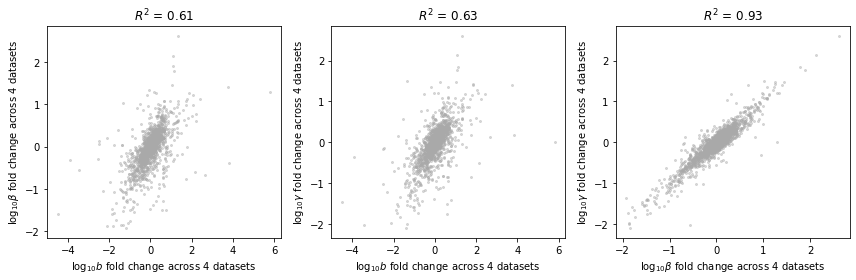

In [24]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = np.zeros(n_genes,dtype=bool)
#     gf = dr_par_multi[:,k1] & dr_par_multi[:,k2]
    
    x = fc_par_multi[:,k1]
    y = fc_par_multi[:,k2]
    
    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(param_names[k1]+' fold change across 4 datasets')
    ax1[q].set_ylabel(param_names[k2]+' fold change across 4 datasets')
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/param_correlations.png'
plt.savefig(fig_string,dpi=450)


## Validation comparisons

First, we define categories for analysis. These are: 
* Modulation in $b$, $\beta$, $\gamma$, $k$
* Modulation in $\mu$
* Cases where $\mu$ intersects with modulation in at least one of the parameters
* Cases where $\neg \mu$ intersects with modulation in any of the parameters

We start by defining the $k$ modulation cases.

In [25]:
dr_par_full = np.concatenate((dr_par,(dr_par[:,:,1] & dr_par[:,:,2])[:,:,None]),2)
fc_kpar = ((fc_par[:,:,1]+fc_par[:,:,2])/2)
fc_par_full = np.concatenate((fc_par,fc_kpar[:,:,None]),2)

In [26]:
dr_par_multi_full = np.concatenate((dr_par_multi,(dr_par_multi[:,1] & dr_par_multi[:,2])[:,None]),1)
fc_kpar_multi = ((fc_par_multi[:,1]+fc_par_multi[:,2])/2)
fc_par_multi_full = np.concatenate((fc_par_multi,fc_kpar_multi[:,None]),1)

### Single-dataset case

Parameter modulation.

First output: Rows are datasets, columns are parameters.
Second output: union.
Third output: intersection.

In [27]:
print(dr_par_full.sum(1))
print(dr_par_full.any(0).sum(0))
print(dr_par_full.all(0).sum(0))

[[53 67 71 56]
 [59 46 61 42]
 [60 48 63 43]
 [41 48 63 44]]
[106  93 115  82]
[16 27 28 22]


 Mean modulation; same conventions.

In [28]:
print(de_ttest.sum(1)[:,None])
print(de_ttest.any(0).sum())
print(de_ttest.all(0).sum())

[[36]
 [13]
 [27]
 [19]]
42
10


Mean and parameter modulation. About 40-60% of the genes identified by $t$-test are also identified by parameters.

In [29]:
print(((dr_par_full.any(2) & de_ttest).sum(1))[:,None])

[[22]
 [ 5]
 [15]
 [11]]


Parameter modulation not accompanied by mean modulation identiable by $t$-test. This appears to be the predominant mode. 

In [30]:
print(((dr_par_full & (~de_ttest)[:,:,None]).sum(1)))

[[46 50 56 42]
 [56 43 57 39]
 [54 36 52 32]
 [38 40 55 37]]


### Multi-dataset case

Parameter modulation.

In [31]:
print(dr_par_multi_full.sum(0))

[22 16 16  6]


Mean modulation.

In [32]:
print(de_ttest_multi.sum())

4


Mean and parameter modulation. The means identified as distinct do not have sufficiently large discrepancies in distributions.

In [33]:
print(((dr_par_multi_full.any(1) & de_ttest_multi).sum()))

0


Parameter modulation not accompanied by mean modulation identiable by $t$-test. Again, this overwhelmingly predominates.

In [34]:
print(((dr_par_multi_full & (~de_ttest_multi)[:,None]).sum(0)))

[22 16 16  6]


### Fixed-point iteration / validation comparison

Genes that appear as DR in any or all of the single-dataset results, as well as in validation.

In [35]:
print((dr_par_full.any(0) & dr_par_multi_full).sum(0))
print((dr_par_full.all(0) & dr_par_multi_full).sum(0))

[15 15 15  6]
[4 8 9 4]


Genes identified as DE, analogously. This is less robust.

In [36]:
print((de_ttest.any(0) & de_ttest_multi).sum(0))
print((de_ttest.all(0) & de_ttest_multi).sum(0))

1
0


Genes identified as DR but not DE. This is a large fraction of them.

In [37]:
print(((dr_par_full & ~de_ttest[:,:,None]).any(0) & dr_par_multi_full & ~de_ttest_multi[:,None]).sum(0))
print(((dr_par_full & ~de_ttest[:,:,None]).all(0) & dr_par_multi_full & ~de_ttest_multi[:,None]).sum(0))

[14 13 13  4]
[4 3 3 2]


Let us consider the genes identified as DR in validation and at least one of the single-dataset cases, but nowhere identified as DE.

In [38]:
gf_drnotde = ((dr_par_full & ~de_ttest[:,:,None]).any(0) & dr_par_multi_full & ~de_ttest_multi[:,None])

### Gene identities

In [39]:
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 k')

for k in range(n_phys_pars+1):
    print('Parameter: '+param_names_text[k])
    print(gn[gf_drnotde[:,k]])

Parameter: log10 b
['Cacnb2' 'Camk2a' 'Extl3' 'Garnl3' 'Kcnh3' 'Lpgat1' 'Ndst1' 'Nhsl2'
 'Nrip1' 'Prkce' 'Sdk2' 'Sv2b' 'Syngap1' 'Tle4']
Parameter: log10 beta
['2010300C02Rik' 'A230006K03Rik' 'Ano3' 'Arpp21' 'Baiap2' 'Dlg1' 'Mast3'
 'Pcsk2' 'Phf24' 'Satb2' 'Slc8a2' 'Srgap3' 'Sv2b']
Parameter: log10 gamma
['A230006K03Rik' 'Adgrl2' 'Cap2' 'Dlg1' 'Igsf9b' 'Ildr2' 'Lingo1'
 'Osbpl1a' 'Rap1gap2' 'Rasgrp1' 'Satb2' 'Sirpa' 'Sv2b']
Parameter: log10 k
['A230006K03Rik' 'Dlg1' 'Satb2' 'Sv2b']


Now, let us consider the genes with less than twofold modulation according to $t$-test performed in validation.

In [40]:
gf_fc = np.abs(fc_mean)<1
gf = gf_drnotde & gf_fc[:,None]

In [41]:
for k in range(n_phys_pars+1):
    print('Parameter: '+param_names_text[k])
    print(gn[gf[:,k]])

Parameter: log10 b
['Cacnb2' 'Camk2a' 'Extl3' 'Kcnh3' 'Lpgat1' 'Ndst1' 'Nhsl2' 'Prkce' 'Sv2b'
 'Syngap1']
Parameter: log10 beta
['2010300C02Rik' 'A230006K03Rik' 'Ano3' 'Arpp21' 'Baiap2' 'Dlg1' 'Mast3'
 'Pcsk2' 'Phf24' 'Satb2' 'Slc8a2' 'Srgap3' 'Sv2b']
Parameter: log10 gamma
['A230006K03Rik' 'Adgrl2' 'Cap2' 'Dlg1' 'Igsf9b' 'Ildr2' 'Lingo1'
 'Osbpl1a' 'Rap1gap2' 'Rasgrp1' 'Satb2' 'Sirpa' 'Sv2b']
Parameter: log10 k
['A230006K03Rik' 'Dlg1' 'Satb2' 'Sv2b']


Finally, let's look at the fits.

In [42]:
gf = np.logical_or(gf[:,0], gf[:,3])

In [43]:
j=2

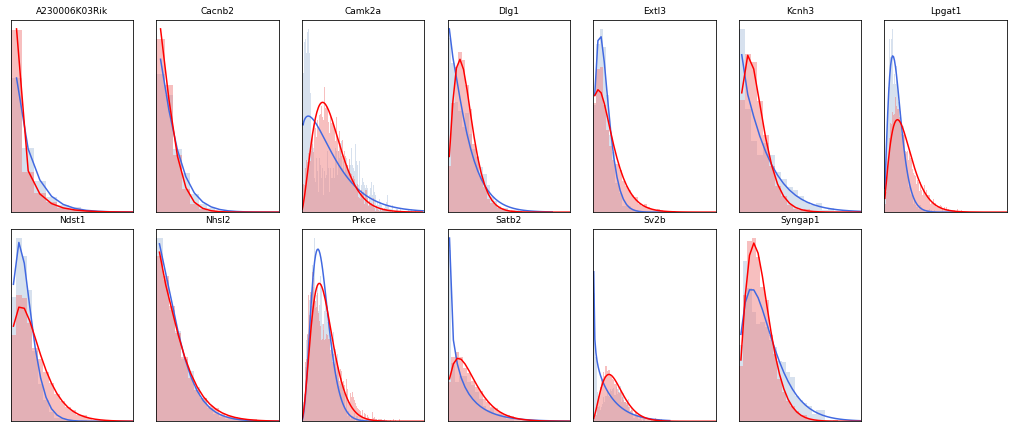

In [44]:

compare_gene_distributions([sr_arr_gaba[j],sr_arr_glu[j]],[sd_arr_gaba[j],sd_arr_glu[j]],sz = (2,7),figsize = (14,6),\
               marg='mature',logscale=None,title=True,\
               genes_to_plot = gf)
plt.gcf().delaxes(plt.gca())

fig_string = sr_arr_gaba[0].batch_analysis_string+'/matdist.png'
plt.savefig(fig_string,dpi=450)


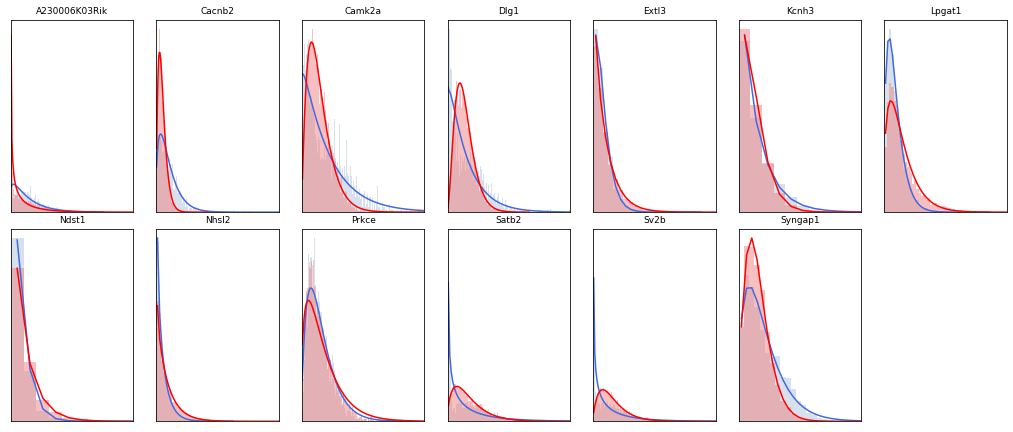

In [45]:
compare_gene_distributions([sr_arr_gaba[j],sr_arr_glu[j]],[sd_arr_gaba[j],sd_arr_glu[j]],sz = (2,7),figsize = (14,6),\
               marg='nascent',logscale=None,title=True,\
               genes_to_plot = gf)

plt.gcf().delaxes(plt.gca())
fig_string = sr_arr_gaba[0].batch_analysis_string+'/nasdist.png'
plt.savefig(fig_string,dpi=450)


Several genes are conspicuously bimodal, but have not been rejected by the chi-squared procedure. This is possibly due to internal heterogeneity, particularly in the GABAergic class (blue).